In [1]:
#!/usr/bin/env python
# coding: utf-8

import os, sys
import logging

import numpy as np
import h5netcdf

import xarray as xr
import xarray.ufuncs as xu
import xrft
import pandas as pd
from scipy.signal import convolve2d, detrend

from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy

plt.rc("figure", figsize=(12,10))
plt.rc("font", size=14)

from dask.distributed import Client, LocalCluster
#
# Initialisation d'un cluster de 32 coeurs
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=4, silence_logs='error')
client = Client(cluster)
client

/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39293 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://137.129.155.67:39293/status,
Dashboard: http://137.129.155.67:39293/status,Workers: 1
Total threads: 4,Total memory: 78.61 GiB
Status: running,Using processes: False
Comm: inproc://137.129.155.67/456/1,Workers: 1
Dashboard: http://137.129.155.67:39293/status,Total threads: 4
Started: Just now,Total memory: 78.61 GiB
Comm: inproc://137.129.155.67/456/4,Total threads: 4
Dashboard: http://137.129.155.67:47693/status,Memory: 78.61 GiB
Nanny: None,


In [2]:
path = "/home/durand/Documents/OLR/"

indir_data = path + 'Anomaly/'
outdir_TF = path + 'TF2D/'

indir_data_RAW = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/RAW_ANOMALY/OLR/'
indir_data_FILTERED = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/FILTERED_ANOMALY/OLR/'

var_file = 'anom_OLR_brut_ERA5_3H'


In [3]:
year = 2001
latitude = -10.5
longitude = 105.5

ds_RAW = xr.open_mfdataset(indir_data_RAW+'*'+var_file+'*'+str(year)+'.nc', chunks = {'time' : 1}, parallel=True)
ds_RAW.assign_coords(lon=(((ds_RAW.lon + 180) % 360) - 180))
# ds_RAW = ds_RAW.isel(time = slice(0,None,8))
ds_FILTER = xr.open_mfdataset(indir_data_FILTERED + '*' + str(year) + '.nc', chunks = {'time' : 1}, parallel=True)
ds_FILTER_2 = xr.open_mfdataset(indir_data_FILTERED + 'ER_SECOND.nc', chunks = {'time' : 1}, parallel=True)

# ds_FILTER = ds_FILTER.isel(time = slice(0,None,8))
ds_ERWAN = xr.open_mfdataset('/cnrm/tropics/user/peyrille/Stage_PFE_Erwan/data/OLR/'+'*'+str(year)+'.nc', chunks = {'time' : 1}, parallel=True)
# ds_ERWAN

In [4]:
da_OLR_Kelvin = ds_FILTER['OLR_Kelvin']
da_OLR_Rossby = ds_FILTER['OLR_Rossby']
da_OLR_MJO = ds_FILTER['OLR_MJO']
da_OLR_MRG = ds_FILTER['OLR_MRG']
da_OLR_EIG = ds_FILTER['OLR_EIG']
da_OLR_WIG = ds_FILTER['OLR_WIG']
da_OLR_TD = ds_FILTER['OLR_TD']
da_OLR_LF = ds_FILTER['OLR_LF'] 

In [5]:
da_FILTER_TOT = da_OLR_Kelvin + \
                da_OLR_Rossby + \
                da_OLR_MJO + \
                da_OLR_MRG + \
                da_OLR_EIG + \
                da_OLR_WIG + \
                da_OLR_TD + \
                da_OLR_LF

In [6]:
da_OLR_Rossby.sel(lat = latitude, lon = longitude, method = 'nearest')

<xarray.DataArray 'OLR_Rossby' (time: 2920)>
dask.array<getitem, shape=(2920,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 ... 2001-12-31T21:00:00
    lat      float32 -10.5
    lon      float32 105.5
Attributes:
    tMin:     9.7
    tMax:     72.0
    kMin:     -10
    kMax:     -1
    hMin:     8
    hMax:     90

In [7]:
ds_FILTER_2

<xarray.Dataset>
Dimensions:   (lat: 13, lon: 144, time: 731)
Coordinates:
  * lat       (lat) float32 -15.0 -12.5 -10.0 -7.5 -5.0 ... 7.5 10.0 12.5 15.0
  * lon       (lon) float32 -177.5 -175.0 -172.5 -170.0 ... 175.0 177.5 180.0
  * time      (time) datetime64[ns] 2000-12-26 2000-12-27 ... 2002-12-26
Data variables:
    olr_anom  (time, lat, lon) float32 dask.array<chunksize=(1, 13, 144), meta=np.ndarray>

In [13]:
ds_ERWAN['er_wk']

<xarray.DataArray 'er_wk' (time: 365, lat: 33, lon: 144)>
dask.array<open_dataset-204be238f6a8352394f84a1dcab420b9er_wk, shape=(365, 33, 144), dtype=float32, chunksize=(1, 33, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -40.0 -37.5 -35.0 -32.5 -30.0 ... 32.5 35.0 37.5 40.0
  * lon      (lon) float32 -177.5 -175.0 -172.5 -170.0 ... 175.0 177.5 180.0
  * time     (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2001-12-31
Attributes: (12/17)
    name:                  eq. Rossby filter from wheeler kiladis 
    valid_range:           [-32765  17235]
    parent_stat:           Individual Obs
    statistic:             Mean
    level_desc:            Other
    dataset:               NOAA Interpolated OLR
    ...                    ...
    long_name:              olr anomaly
    lat:                   40.0
    wavenumber:            [-10  -1]
    period:                [ 9.7 48. ]
    depth:                 [ 8 90]
    waveName:              ER

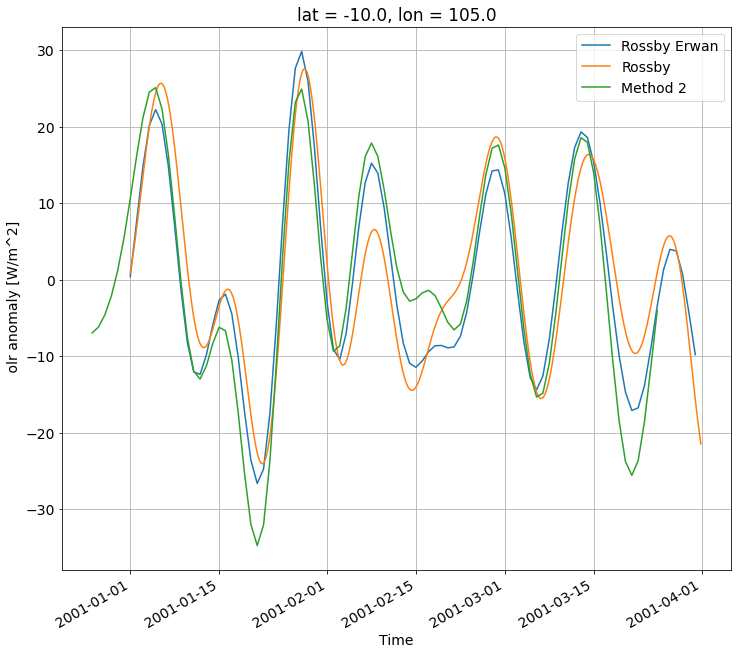

In [8]:
ds_ERWAN['er_wk'].sel(lat = latitude, lon = longitude, method = 'nearest').isel(time = slice(0, 90)).plot(label = 'Rossby Erwan')
da_OLR_Rossby.sel(lat = latitude, lon = longitude, method = 'nearest').isel(time = slice(0, 90*8)).plot(label = 'Rossby')
ds_FILTER_2['olr_anom'].sel(lat = latitude, lon = longitude, method = 'nearest').isel(time = slice(0, 90)).plot(label = 'Method 2')
plt.legend()
plt.grid()

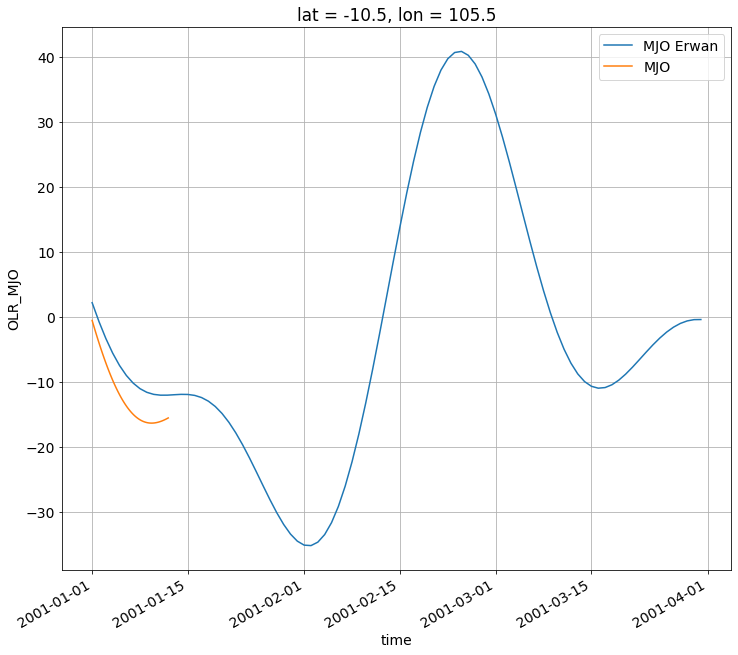

In [9]:
ds_ERWAN['mjo_wk'].sel(lat = latitude, lon = longitude, method = 'nearest').isel(time = slice(0, 90)).plot(label = 'MJO Erwan')
da_OLR_MJO.sel(lat = latitude, lon = longitude, method = 'nearest').isel(time = slice(0, 90)).plot(label = 'MJO')
plt.legend()
plt.grid()

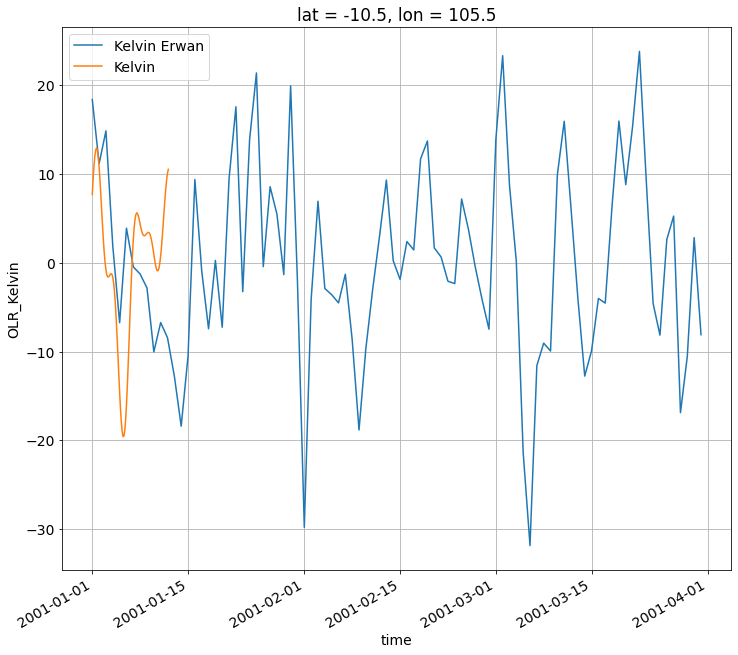

In [10]:
ds_ERWAN['klv_wk'].sel(lat = latitude, lon = longitude, method = 'nearest').isel(time = slice(0, 90)).plot(label = 'Kelvin Erwan')
da_OLR_Kelvin.sel(lat = latitude, lon = longitude, method = 'nearest').isel(time = slice(0, 90)).plot(label = 'Kelvin')
plt.legend()
plt.grid()

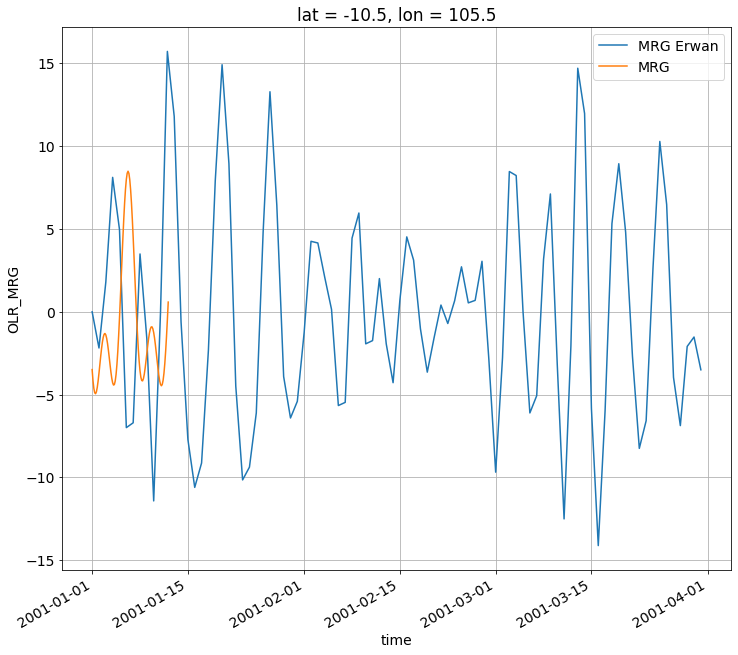

In [11]:
ds_ERWAN['mrg'].sel(lat = latitude, lon = longitude, method = 'nearest').isel(time = slice(0, 90)).plot(label = 'MRG Erwan')
da_OLR_MRG.sel(lat = latitude, lon = longitude, method = 'nearest').isel(time = slice(0, 90)).plot(label = 'MRG')
plt.legend()
plt.grid()

In [12]:
ds_ERWAN['mrg']

<xarray.DataArray 'mrg' (time: 365, lat: 33, lon: 144)>
dask.array<open_dataset-204be238f6a8352394f84a1dcab420b9mrg, shape=(365, 33, 144), dtype=float32, chunksize=(1, 33, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -40.0 -37.5 -35.0 -32.5 -30.0 ... 32.5 35.0 37.5 40.0
  * lon      (lon) float32 -177.5 -175.0 -172.5 -170.0 ... 175.0 177.5 180.0
  * time     (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2001-12-31
Attributes: (12/17)
    name:                  low frequency 
    valid_range:           [-32765  17235]
    parent_stat:           Individual Obs
    statistic:             Mean
    level_desc:            Other
    dataset:               NOAA Interpolated OLR
    ...                    ...
    long_name:              olr anomaly
    lat:                   40.0
    wavenumber:            [-20  -1]
    period:                [ 3. 10.]
    depth:                 [ 8 90]
    waveName:              MRG